### 데이터 셋업

In [52]:
# ======1단계: 입력 폴더 경로 설정
path_in = r"..\assets\ply\impeller\4wings"   # Windows 경로 예시
downsample_N = 10000         # 각각 포인트 샘플링 수
DOWNSAMPLE_N = 4000 

In [ ]:
# ====== 설정 ======
from pathlib import Path
import numpy as np
import open3d as o3d

BASE_DIR     = Path(r"..\assets\ply\impeller\4wings")
INPUT_DIR    = BASE_DIR / "ply"   # ← PLY 읽는 폴더
OUTPUT_DIR   = BASE_DIR / "xyz"   # ← XYZ 저장 폴더

SUFFIX       = "_point"           # 저장 파일명 접미사 (원치 않으면 "")

np.random.seed(42)

# ====== 변환 함수 ======
def convert_ply_to_xyz(ply_path: Path, out_dir: Path, n_points: int = 1000, suffix: str = "_point"):
    """
    단일 .ply → 점군(.xyz) 저장
    - 삼각형 메쉬면 Poisson 디스크 샘플링
    - 포인트클라우드면 랜덤 다운샘플
    """
    # 1) 먼저 메쉬로 시도
    mesh = o3d.io.read_triangle_mesh(str(ply_path))
    pcd = None
    if mesh is not None and mesh.has_vertices() and mesh.has_triangles():
        try:
            pcd = mesh.sample_points_poisson_disk(number_of_points=int(n_points))
        except Exception as e:
            print(f"[WARN] 메쉬 샘플링 실패 → 포인트클라우드로 재시도: {ply_path.name} ({e})")

    # 2) 메쉬가 아니거나 실패 시 포인트클라우드로 읽기
    if pcd is None:
        pc = o3d.io.read_point_cloud(str(ply_path))
        pts = np.asarray(pc.points)
        if pts.size == 0:
            print(f"[ERR] 포인트가 없습니다: {ply_path}")
            return None
        if len(pts) > n_points:
            idx = np.random.choice(len(pts), int(n_points), replace=False)
            pts = pts[idx]
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts))

    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{ply_path.stem}{suffix}.xyz"
    np.savetxt(out_path, np.asarray(pcd.points), fmt="%.6f")
    print(f"[OK] {ply_path.name} → {out_path} (N={len(pcd.points)})")
    return out_path

# ====== 일괄 변환 ======
def batch_convert(input_dir: Path, output_dir: Path, n_points: int = 1000, suffix: str = "_point"):
    if not input_dir.is_dir():
        print(f"[ERR] 입력 폴더가 존재하지 않습니다: {input_dir}")
        return
    ply_files = sorted(list(input_dir.glob("*.ply")) + list(input_dir.glob("*.PLY")))
    if not ply_files:
        print(f"[INFO] PLY 파일이 없습니다: {input_dir}")
        return

    cnt = 0
    for ply in ply_files:
        if convert_ply_to_xyz(ply, output_dir, n_points, suffix) is not None:
            cnt += 1
    print(f"[DONE] 총 {cnt}/{len(ply_files)} 개 파일 변환 완료.  (in: {input_dir} → out: {output_dir})")

# 실행
batch_convert(INPUT_DIR, OUTPUT_DIR, DOWNSAMPLE_N, SUFFIX)


[OK] imp001.ply → ..\assets\ply\impeller\4wings\xyz\imp001_point.xyz (N=4000)
[OK] imp001.ply → ..\assets\ply\impeller\4wings\xyz\imp001_point.xyz (N=4000)
[OK] imp002.ply → ..\assets\ply\impeller\4wings\xyz\imp002_point.xyz (N=4000)
[OK] imp002.ply → ..\assets\ply\impeller\4wings\xyz\imp002_point.xyz (N=4000)
[OK] imp003.ply → ..\assets\ply\impeller\4wings\xyz\imp003_point.xyz (N=4000)
[OK] imp003.ply → ..\assets\ply\impeller\4wings\xyz\imp003_point.xyz (N=4000)
[OK] imp004.ply → ..\assets\ply\impeller\4wings\xyz\imp004_point.xyz (N=4000)
[OK] imp004.ply → ..\assets\ply\impeller\4wings\xyz\imp004_point.xyz (N=4000)
[OK] imp005.ply → ..\assets\ply\impeller\4wings\xyz\imp005_point.xyz (N=4000)
[OK] imp005.ply → ..\assets\ply\impeller\4wings\xyz\imp005_point.xyz (N=4000)
[OK] imp006.ply → ..\assets\ply\impeller\4wings\xyz\imp006_point.xyz (N=4000)
[OK] imp006.ply → ..\assets\ply\impeller\4wings\xyz\imp006_point.xyz (N=4000)
[OK] imp007.ply → ..\assets\ply\impeller\4wings\xyz\imp007_point

In [50]:
import numpy as np

# ====== xyz 파일 병합 및 imp_merged.xyz 생성 ======
BASE_DIR     = Path(r"..\assets\ply\impeller\4wings")
INPUT_DIR    = BASE_DIR / "xyz"   # ← PLY 읽는 폴더
OUTPUT_DIR   = BASE_DIR / "xyz_merged"   # ← XYZ 저장 폴더

xyz_files = sorted(INPUT_DIR.glob("*.xyz"))
if not xyz_files:
    print(f"[INFO] {INPUT_DIR} 안에 .xyz 파일이 없습니다.")
else:
    merged_xyz = []
    for f in xyz_files:
        data = np.loadtxt(f)
        if data.ndim == 1:
            if data.size % 3 != 0:
                print(f"[WARN] {f.name} 포인트 형식 오류 → 스킵")
                continue
            data = data.reshape(-1, 3)
        merged_xyz.append(data)
        print(f"[READ] {f.name} (N={len(data)})")
    if merged_xyz:
        merged_xyz = np.vstack(merged_xyz)
        OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        merged_path = OUTPUT_DIR / "imp_merged.xyz"
        np.savetxt(merged_path, merged_xyz, fmt="%.6f")
        print(f"[DONE] {len(xyz_files)}개 파일 병합 → {merged_path} (총 포인트: {len(merged_xyz):,d})")
    else:
        print("[INFO] 병합할 데이터가 없습니다.")

#실행


[READ] imp001_point.xyz (N=4000)
[READ] imp002_point.xyz (N=4000)
[READ] imp003_point.xyz (N=4000)
[READ] imp004_point.xyz (N=4000)
[READ] imp005_point.xyz (N=4000)
[READ] imp006_point.xyz (N=4000)
[READ] imp007_point.xyz (N=4000)
[READ] imp008_point.xyz (N=4000)
[READ] imp009_point.xyz (N=4000)
[READ] imp010_point.xyz (N=4000)
[READ] imp011_point.xyz (N=4000)
[READ] imp012_point.xyz (N=4000)
[READ] imp013_point.xyz (N=4000)
[READ] imp014_point.xyz (N=4000)
[READ] imp015_point.xyz (N=4000)
[READ] imp016_point.xyz (N=4000)
[READ] imp017_point.xyz (N=4000)
[READ] imp018_point.xyz (N=4000)
[READ] imp019_point.xyz (N=4000)
[READ] imp020_point.xyz (N=4000)
[READ] imp021_point.xyz (N=4000)
[READ] imp022_point.xyz (N=4000)
[READ] imp023_point.xyz (N=4000)
[READ] imp024_point.xyz (N=4000)
[READ] imp025_point.xyz (N=4000)
[READ] imp026_point.xyz (N=4000)
[DONE] 26개 파일 병합 → ..\assets\ply\impeller\4wings\xyz_merged\imp_merged.xyz (총 포인트: 104,000)


In [51]:
import numpy as np
import re
from pathlib import Path
from typing import Optional   # ← 추가

# ====== 경로 설정 ======
BASE_DIR = Path(r"..\assets\ply\impeller\4wings")
IN_DIR   = BASE_DIR / "xyz"    # .xyz 읽기
OUT_DIR  = BASE_DIR / "xyzc"   # .xyzc 저장
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ====== 3단계: .xyz 파일 → .xyzc 파일로 변환 ======
def convert_xyz_to_xyzc(xyz_path: Path, out_dir: Path) -> Optional[Path]:  # ← 수정
    """
    파일명에서 '마지막 숫자 묶음'을 라벨로 사용 → .xyzc 저장
      impeller_b3_010_point.xyz -> 라벨 10.00000000
      imp001_point.xyz          -> 라벨 1.00000000
    """
    stem = xyz_path.stem
    nums = re.findall(r'\d+', stem)
    if not nums:
        print(f"[SKIP] 라벨 숫자 추출 실패: {xyz_path.name}")
        return None

    label_value = float(nums[-1])  # "010"->10.0, "001"->1.0

    xyz = np.loadtxt(xyz_path)
    if xyz.ndim == 1:
        if xyz.size % 3 != 0:
            print(f"[ERR] 포인트 형식이 3열이 아닙니다: {xyz_path}")
            return None
        xyz = xyz.reshape(-1, 3)

    label_column = np.full((xyz.shape[0], 1), label_value, dtype=float)
    xyzc = np.hstack((xyz, label_column))

    out_path = out_dir / f"{xyz_path.stem}.xyzc"
    np.savetxt(out_path, xyzc, fmt="%.6f %.6f %.6f %.8f")
    print(f"[OK] {xyz_path.name} → {out_path.name} (label={label_value:.8f})")
    return out_path

# ====== 폴더 내 모든 .xyz 처리 ======
xyz_files = sorted(list(IN_DIR.glob("*_point.xyz"))) or sorted(list(IN_DIR.glob("*.xyz")))
if not xyz_files:
    print(f"[INFO] {IN_DIR} 안에 처리할 .xyz 파일이 없습니다.")
else:
    ok, skip = 0, 0
    for xyz_file in xyz_files:
        outp = convert_xyz_to_xyzc(xyz_file, OUT_DIR)
        if outp is None: skip += 1
        else: ok += 1
    print(f"[DONE] 총 {len(xyz_files)}개 파일 중 변환 성공 {ok}개, 스킵 {skip}개.")


[OK] imp001_point.xyz → imp001_point.xyzc (label=1.00000000)
[OK] imp002_point.xyz → imp002_point.xyzc (label=2.00000000)
[OK] imp003_point.xyz → imp003_point.xyzc (label=3.00000000)
[OK] imp004_point.xyz → imp004_point.xyzc (label=4.00000000)
[OK] imp005_point.xyz → imp005_point.xyzc (label=5.00000000)
[OK] imp006_point.xyz → imp006_point.xyzc (label=6.00000000)
[OK] imp007_point.xyz → imp007_point.xyzc (label=7.00000000)
[OK] imp008_point.xyz → imp008_point.xyzc (label=8.00000000)
[OK] imp009_point.xyz → imp009_point.xyzc (label=9.00000000)
[OK] imp010_point.xyz → imp010_point.xyzc (label=10.00000000)
[OK] imp011_point.xyz → imp011_point.xyzc (label=11.00000000)
[OK] imp012_point.xyz → imp012_point.xyzc (label=12.00000000)
[OK] imp013_point.xyz → imp013_point.xyzc (label=13.00000000)
[OK] imp014_point.xyz → imp014_point.xyzc (label=14.00000000)
[OK] imp015_point.xyz → imp015_point.xyzc (label=15.00000000)
[OK] imp016_point.xyz → imp016_point.xyzc (label=16.00000000)
[OK] imp017_point

In [16]:
import numpy as np
from pathlib import Path

# ====== 경로 설정 ======
BASE_DIR = Path(r"..\assets\ply\impeller\4wings")
IN_DIR   = BASE_DIR / "xyzc"          # 병합할 개별 .xyzc들이 있는 폴더
OUT_DIR  = BASE_DIR / "xyzc_merged"   # 병합본 저장 폴더
OUT_DIR.mkdir(parents=True, exist_ok=True)

def next_merged_path(out_dir: Path, prefix: str = "merged_", start_idx: int = 1) -> Path:
    """
    out_dir/prefix_XX.xyzc 형태로, 존재하지 않는 가장 낮은 인덱스를 찾아 경로 반환.
    예) merged_01.xyzc, merged_02.xyzc, ...
    """
    i = start_idx
    while True:
        candidate = out_dir / f"{prefix}{i:02d}.xyzc"
        if not candidate.exists():
            return candidate
        i += 1

# ====== 파일 수집 ======
xyzc_files = sorted(IN_DIR.glob("*.xyzc"))
if not xyzc_files:
    print(f"[INFO] {IN_DIR} 안에 .xyzc 파일이 없습니다.")
else:
    merged_chunks = []
    n_files_read = 0
    for f in xyzc_files:
        try:
            data = np.loadtxt(f).astype(np.float32)
            if data.ndim == 1:
                # 한 줄짜리 방지 및 4열 보장
                if data.size % 4 != 0:
                    print(f"[WARN] 열 수가 4의 배수가 아님: {f.name} -> 스킵")
                    continue
                data = data.reshape(-1, 4)
            elif data.shape[1] != 4:
                print(f"[WARN] 4열(.xyzc)이 아님: {f.name} (shape={data.shape}) -> 스킵")
                continue

            merged_chunks.append(data)
            n_files_read += 1
            print(f"[READ] {f.name} (N={len(data)})")
        except Exception as e:
            print(f"[ERR] {f.name} 불러오기 실패: {e}")

    if merged_chunks:
        merged = np.vstack(merged_chunks)
        out_path = next_merged_path(OUT_DIR, prefix="merged_", start_idx=1)
        np.savetxt(out_path, merged, fmt="%.6f %.6f %.6f %.8f")
        print(f"[DONE] {n_files_read}/{len(xyzc_files)} 개 파일 합침 → {out_path}")
        print(f"       총 포인트: {len(merged):,d}")
    else:
        print("[INFO] 합칠 데이터가 없습니다.")


[READ] imp001_point.xyzc (N=10000)
[READ] imp002_point.xyzc (N=10000)
[READ] imp003_point.xyzc (N=10000)
[READ] imp004_point.xyzc (N=10000)
[READ] imp005_point.xyzc (N=10000)
[READ] imp006_point.xyzc (N=10000)
[READ] imp007_point.xyzc (N=10000)
[READ] imp008_point.xyzc (N=10000)
[READ] imp009_point.xyzc (N=10000)
[READ] imp010_point.xyzc (N=10000)
[READ] imp011_point.xyzc (N=10000)
[READ] imp012_point.xyzc (N=10000)
[READ] imp013_point.xyzc (N=10000)
[READ] imp014_point.xyzc (N=10000)
[READ] imp015_point.xyzc (N=10000)
[READ] imp016_point.xyzc (N=10000)
[READ] imp017_point.xyzc (N=10000)
[READ] imp018_point.xyzc (N=10000)
[READ] imp019_point.xyzc (N=10000)
[READ] imp020_point.xyzc (N=10000)
[READ] imp021_point.xyzc (N=10000)
[READ] imp022_point.xyzc (N=10000)
[READ] imp023_point.xyzc (N=10000)
[READ] imp024_point.xyzc (N=10000)
[READ] imp025_point.xyzc (N=10000)
[READ] imp026_point.xyzc (N=10000)
[DONE] 26/26 개 파일 합침 → ..\assets\ply\impeller\4wings\xyzc_merged\merged_31.xyzc
       총 포

여기부터는 모델 학습

In [17]:
# === 1. 기본 설정 ===
import os
import math
import glob
import time
import random
import json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)





DEVICE = cuda


In [18]:
# === 2. 보조 함수 (정규화/증강 등) ===
def normalize_points_xyz(xyz, mode="global"):
    """
    xyz: (N,3)
    mode:
      - "global": 평균 0, 표준편차 1 (등방 스케일)
      - "unit_box": bbox의 가장 긴 변이 1이 되도록 스케일
      - None: 그대로
    """
    xyz = np.asarray(xyz, dtype=np.float32)
    if mode is None:
        return xyz, dict(mean=np.zeros(3), scale=1.0)
    if mode == "global":
        mean = xyz.mean(axis=0)
        scale = xyz.std(axis=0).max()
        scale = float(scale if scale > 0 else 1.0)
        return (xyz - mean) / scale, dict(mean=mean, scale=scale)
    if mode == "unit_box":
        mn = xyz.min(axis=0); mx = xyz.max(axis=0)
        extent = (mx - mn).max()
        extent = float(extent if extent > 0 else 1.0)
        mean = (mx + mn) / 2.0
        return (xyz - mean) / extent, dict(mean=mean, scale=extent)
    raise ValueError("unknown mode")

def jitter(xyz, sigma=0.005, clip=0.02):
    noise = np.random.randn(*xyz.shape).astype(np.float32)  # ← float32 강제
    noise = np.clip(noise * np.float32(sigma), -np.float32(clip), np.float32(clip))
    return (xyz + noise).astype(np.float32)


def rotate_z(xyz, deg=None):
    if deg is None:
        deg = np.random.uniform(0, 360)
    th = np.deg2rad(deg)
    R = np.array([[np.cos(th), -np.sin(th), 0.0],
                  [np.sin(th),  np.cos(th), 0.0],
                  [0.0,         0.0,        1.0]], dtype=np.float32)
    return xyz @ R.T


In [19]:
class XYZCFiles(Dataset):
    def __init__(self, files, normalize="global", augment=False, sample_points=None):
        """
        files: list[path-like] 여러 .xyzc 파일 경로
        normalize: "global" | "unit_box" | None
        augment: 학습 시 지터/회전 증강
        sample_points: None이면 전체, 정수면 샘플링 개수
        """
        self.files = [Path(f) for f in files]
        self.normalize = normalize
        self.augment = augment
        self.sample_points = sample_points

        # 1) 전체 로드
        xyzes, labels = [], []
        for f in self.files:
            arr = np.loadtxt(f).astype(np.float32)
            if arr.ndim == 1: arr = arr.reshape(-1, 4)
            xyz, c = arr[:, :3], arr[:, 3]
            xyzes.append(xyz); labels.append(c)
        xyz_all = np.concatenate(xyzes, axis=0)
        labels_all = np.concatenate(labels, axis=0)

        # 2) 라벨 매핑(정렬/고유)
        uniq = np.unique(labels_all)
        self.lbl2idx = {v:i for i, v in enumerate(uniq)}   # 실제 라벨 → 0..K-1
        self.idx2lbl = {i:v for v,i in self.lbl2idx.items()}
        y_idx = np.vectorize(self.lbl2idx.get)(labels_all)

        # 3) 정규화 파라미터 계산 (전 데이터 기준)
        xyz_all_norm, stats = normalize_points_xyz(xyz_all, mode=normalize)
        self.mean = stats["mean"]; self.scale = stats["scale"]

        # 4) 파일별 인덱스 청크 저장(빠른 접근 용)
        self.samples = []
        offset = 0
        for xyz, c in zip(xyzes, labels):
            n = len(xyz)
            idx_slice = slice(offset, offset+n)
            # 실제 저장은 전체 풀에서 슬라이스로 참조
            self.samples.append(idx_slice)
            offset += n

        # 5) 실제 풀 데이터 저장 (정규화 적용)
        self.xyz_all = ((xyz_all - self.mean) / self.scale).astype(np.float32)
        self.y_all = y_idx.astype(np.int64)

        # 6) 클래스 가중치 (inverse frequency)
        counts = np.bincount(self.y_all)
        freq = counts / counts.sum()
        self.class_weights = (1.0 / np.clip(freq, 1e-8, None)).astype(np.float32)
        self.class_weights = self.class_weights * (len(self.class_weights) / self.class_weights.sum())

        print(f"[Dataset] 총 포인트: {len(self.xyz_all):,}, 클래스 수: {len(self.class_weights)}")
        print("[Dataset] 고유라벨(원본) → 인덱스:", self.lbl2idx)

    def __len__(self):
        # 배치에 (B,3,N) 형태로 넣을거라 개별 포인트 샘플 보단
        # '파일 단위' 아이템이 낫다. 파일 수를 길이로 보자.
        return len(self.samples)

    def __getitem__(self, i):
        sl = self.samples[i]
        xyz = self.xyz_all[sl]
        y = self.y_all[sl]

        # 파일 단위에서 다시 포인트 샘플링 (선택)
        if (self.sample_points is not None) and (len(xyz) > self.sample_points):
            idx = np.random.choice(len(xyz), self.sample_points, replace=False)
            xyz = xyz[idx]; y = y[idx]

        if self.augment:
            xyz = rotate_z(xyz)  # 임펠러류에 유용한 z회전 불변성
            xyz = jitter(xyz)

        # (N,3), (N,) 반환 → collate에서 (B,N,3)로 쌓고 (B,3,N)로 전치
        return torch.from_numpy(xyz), torch.from_numpy(y)


In [20]:
# === collate_fn 정의 (파일 단위 배치를 한 덩어리로 합쳐서 반환) ===
import torch

def collate_fn(batch):
    """
    batch: [(xyz_i:(Ni,3), y_i:(Ni,)), ...] 길이 = batch_size(파일 수)
    반환: xyz:(sumN,3), y:(sumN,)  -> 이후 학습 루프에서 (1,3,sumN) 형태로 변환
    """
    xyzs = [b[0] for b in batch]
    ys   = [b[1] for b in batch]
    xyz  = torch.cat(xyzs, dim=0)   # (sumN, 3)
    y    = torch.cat(ys,   dim=0)   # (sumN,)

    # 섞어서 학습 안정화 (선택적)
    perm = torch.randperm(xyz.size(0))
    xyz  = xyz[perm]
    y    = y[perm]
    return xyz, y


In [21]:
# === 데이터셋 생성 ===
# 예) data_dir 안의 여러 *.xyzc 사용
data_dir = r"..\assets\ply\impeller\4wings\xyzc_merged"
files = sorted(glob.glob(os.path.join(data_dir, "*.xyzc")))
dataset = XYZCFiles(files, normalize="global", augment=True, sample_points=40_000)


# 학습/검증 분할(파일 단위)
val_ratio = 0.1
n_val = max(1, int(len(dataset) * val_ratio))
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))
len(train_set), len(val_set)


[Dataset] 총 포인트: 1,040,000, 클래스 수: 26
[Dataset] 고유라벨(원본) → 인덱스: {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8, 10.0: 9, 11.0: 10, 12.0: 11, 13.0: 12, 14.0: 13, 15.0: 14, 16.0: 15, 17.0: 16, 18.0: 17, 19.0: 18, 20.0: 19, 21.0: 20, 22.0: 21, 23.0: 22, 24.0: 23, 25.0: 24, 26.0: 25}


(28, 3)

In [22]:
class MiniPointNetSeg(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(3,    64, 1)
        self.conv2 = nn.Conv1d(64,  128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256+64, 256, 1)
        self.bn4 = nn.BatchNorm1d(256)
        self.conv5 = nn.Conv1d(256, 128, 1)
        self.bn5 = nn.BatchNorm1d(128)
        self.classifier = nn.Conv1d(128, num_classes, 1)

    def forward(self, x):          # x: (B,3,N)
        x1 = F.relu(self.bn1(self.conv1(x)))      # (B,64,N)
        x2 = F.relu(self.bn2(self.conv2(x1)))     # (B,128,N)
        x3 = F.relu(self.bn3(self.conv3(x2)))     # (B,256,N)
        g  = torch.max(x3, dim=2, keepdim=True)[0]# (B,256,1) 전역맥스
        g  = g.repeat(1, 1, x.size(2))            # (B,256,N)
        x  = torch.cat([x1, g], dim=1)            # (B,64+256,N)
        x  = F.relu(self.bn4(self.conv4(x)))      # (B,256,N)
        x  = F.relu(self.bn5(self.conv5(x)))      # (B,128,N)
        out = self.classifier(x)                  # (B,C,N)
        return out


In [23]:


BATCH_FILES = 2            # 파일 2개씩 묶어서 한 배치 취급
POINTS_PER_STEP = 80_000   # 학습 step마다 사용할 포인트 수(메모리 예산에 맞춰 조절)

pin = (DEVICE.type == "cuda")
train_loader = DataLoader(train_set, batch_size=BATCH_FILES, shuffle=True,
                          num_workers=0, pin_memory=pin, collate_fn=collate_fn, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False,
                          num_workers=0, pin_memory=pin, collate_fn=collate_fn)



In [24]:
num_classes = len(dataset.class_weights)
model = MiniPointNetSeg(num_classes=num_classes).to(DEVICE)
class_weights = torch.tensor(dataset.class_weights, dtype=torch.float32, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

def random_pick_points(xyz, y, k):
    n = xyz.size(0)
    if n <= k:
        idx = torch.arange(n, device=xyz.device)
    else:
        idx = torch.randperm(n, device=xyz.device)[:k]  # ← 중복 없음
    return xyz[idx], y[idx]


def train_one_epoch(epoch):
    model.train()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    for xyz, y in train_loader:
        xyz = xyz.to(DEVICE); y = y.to(DEVICE)
        xyz, y = random_pick_points(xyz, y, POINTS_PER_STEP)

        # (N,3) -> (1,3,N)
        x = xyz.T.unsqueeze(0)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            logits = model(x)          # (1,C,N)
            logits = logits.squeeze(0).T  # (N,C)로 변환
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            acc = (pred==y).float().mean().item()
        total_loss += loss.item() * y.numel()
        total_acc  += acc * y.numel()
        total_n    += y.numel()

    print(f"[Train {epoch}] loss={total_loss/total_n:.4f} acc={total_acc/total_n:.4f}")

def evaluate(epoch):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    with torch.no_grad():
        for xyz, y in val_loader:
            xyz = xyz.to(DEVICE); y = y.to(DEVICE)
            xyz, y = random_pick_points(xyz, y, min(POINTS_PER_STEP, len(xyz)))
            x = xyz.T.unsqueeze(0)
            logits = model(x).squeeze(0).T
            loss = criterion(logits, y)
            pred = logits.argmax(dim=1)
            acc = (pred==y).float().mean().item()
            total_loss += loss.item() * y.numel()
            total_acc  += acc * y.numel()
            total_n    += y.numel()
    print(f"[Valid {epoch}] loss={total_loss/total_n:.4f} acc={total_acc/total_n:.4f}")
    return total_loss/total_n


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

In [ ]:
# === Confusion Matrix 유틸 ===
import torch

def update_confmat(cm: torch.Tensor, y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int):
    """
    cm: (C,C) on DEVICE, long
    y_true, y_pred: (N,) long, 값 범위 [0, C-1]
    """
    y_true = y_true.to(dtype=torch.long)
    y_pred = y_pred.to(dtype=torch.long)
    idx = y_true * num_classes + y_pred  # (N,)
    # bincount은 long 필요 / minlength로 (C*C) 고정
    binc = torch.bincount(idx, minlength=num_classes * num_classes)
    cm += binc.view(num_classes, num_classes)
    return cm

def summarize_cm(cm: torch.Tensor):
    """
    cm: (C,C) long/float on DEVICE
    반환: dict(mean_iou, mean_class_acc, overall_acc, iou_per_class, acc_per_class)
    """
    cm = cm.to(torch.float32)
    tp = torch.diag(cm)                 # (C,)
    fp = cm.sum(dim=0) - tp             # (C,)
    fn = cm.sum(dim=1) - tp             # (C,)
    denom_iou = tp + fp + fn + 1e-9
    iou = tp / denom_iou                # (C,)

    denom_acc = cm.sum(dim=1).clamp_min(1.0)
    acc_cls = tp / denom_acc            # (C,)

    mean_iou = iou.mean().item()
    mean_acc = acc_cls.mean().item()
    overall_acc = (tp.sum() / cm.sum().clamp_min(1.0)).item()

    return {
        "mean_iou": float(mean_iou),
        "mean_class_acc": float(mean_acc),
        "overall_acc": float(overall_acc),
        "iou_per_class": iou.detach().cpu().numpy(),
        "acc_per_class": acc_cls.detach().cpu().numpy(),
    }


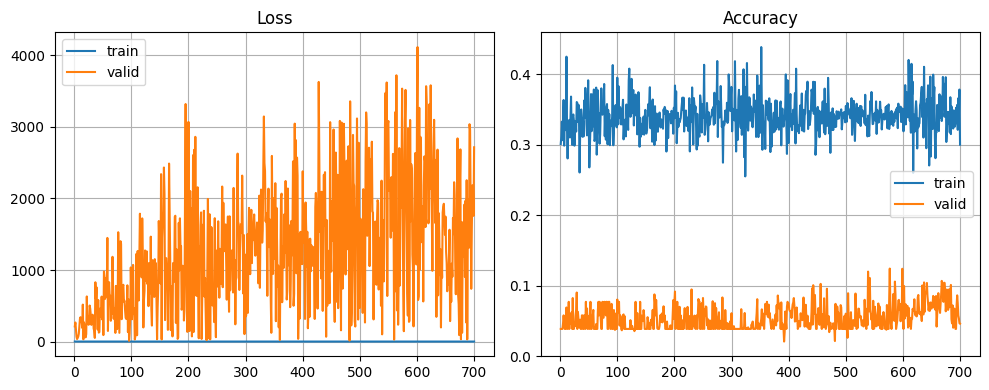

[Epoch 700] train_loss=1.5307 val_loss=2715.3030 (took 0.5s)


Train 701:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 701:   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 701] train_loss=1.5262 val_loss=1520.1462 (took 0.3s)


Train 702:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 702:   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 702] train_loss=1.5231 val_loss=400.8100 (took 0.3s)


Train 703:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

In [ ]:
from tqdm.auto import tqdm
import time, os, pandas as pd, matplotlib.pyplot as plt
from IPython.display import clear_output

history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def plot_history(hist):
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(hist["epoch"], hist["train_loss"], label="train")
    axes[0].plot(hist["epoch"], hist["val_loss"],   label="valid")
    axes[0].set_title("Loss"); axes[0].legend(); axes[0].grid(True)
    axes[1].plot(hist["epoch"], hist["train_acc"], label="train")
    axes[1].plot(hist["epoch"], hist["val_acc"],   label="valid")
    axes[1].set_title("Accuracy"); axes[1].legend(); axes[1].grid(True)
    plt.tight_layout(); plt.show()

def save_history_csv(hist, save_dir="./checkpoints_xyzc"):
    os.makedirs(save_dir, exist_ok=True)
    pd.DataFrame(hist).to_csv(os.path.join(save_dir, "training_history.csv"), index=False)

def train_one_epoch(epoch):
    model.train()
    total_loss, total_correct, total_n = 0.0, 0, 0
    it = tqdm(train_loader, desc=f"Train {epoch}", dynamic_ncols=True, leave=False, position=1)
    for step, (xyz, y) in enumerate(it, 1):
        xyz = xyz.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        xyz, y = random_pick_points(xyz, y, POINTS_PER_STEP)
        x = xyz.T.unsqueeze(0)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            logits = model(x).squeeze(0).T
            loss = criterion(logits, y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            total_correct += (pred == y).sum().item()
            total_loss    += loss.item() * y.numel()
            total_n       += y.numel()

        it.set_postfix({
            "step": step,
            "avg_loss": f"{total_loss/max(1,total_n):.4f}",
            "avg_acc":  f"{total_correct/max(1,total_n):.4f}",
            **({"VRAM": f"{torch.cuda.memory_allocated()/(1024**3):.1f}G"} if DEVICE.type=="cuda" else {})
        })

    return total_loss/max(1,total_n), total_correct/max(1,total_n)

def evaluate(epoch, compute_cm=True):
    model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    cm = torch.zeros(num_classes, num_classes, dtype=torch.long, device=DEVICE) if compute_cm else None
    it = tqdm(val_loader, desc=f"Valid {epoch}", dynamic_ncols=True, leave=False, position=2)
    with torch.no_grad():
        for step, (xyz, y) in enumerate(it, 1):
            xyz = xyz.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
            xyz, y = random_pick_points(xyz, y, min(POINTS_PER_STEP, len(xyz)))
            x = xyz.T.unsqueeze(0)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
                logits = model(x).squeeze(0).T
                loss = criterion(logits, y)
            pred = logits.argmax(dim=1)

            total_correct += (pred == y).sum().item()
            total_loss    += loss.item() * y.numel()
            total_n       += y.numel()
            if compute_cm: cm = update_confmat(cm, y, pred, num_classes)

            it.set_postfix({
                "step": step,
                "avg_loss": f"{total_loss/max(1,total_n):.4f}",
                "avg_acc":  f"{total_correct/max(1,total_n):.4f}",
            })

    stats = summarize_cm(cm) if (compute_cm and cm is not None) else None
    return total_loss/max(1,total_n), total_correct/max(1,total_n), (cm.detach().cpu() if cm is not None else None), stats

# === 학습 실행 ===
EPOCHS   = 30000
best_loss = float("inf")
save_dir  = "./checkpoints_xyzc"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "pointnet_xyzc.pt")

last_cm = None
last_stats = None

outer = tqdm(range(1, EPOCHS+1), desc="Epochs", dynamic_ncols=True, position=0, leave=True)
for epoch in outer:
    if DEVICE.type == "cuda": torch.cuda.synchronize()
    t0 = time.time()

    tr_loss, tr_acc = train_one_epoch(epoch)
    val_loss, val_acc, cm, stats = evaluate(epoch, compute_cm=True)

    # 히스토리/CSV/그래프
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);  history["val_acc"].append(val_acc)
    save_history_csv(history, save_dir=save_dir)
    if epoch % 5 == 0: plot_history(history)

    # best 갱신
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            "model": model.state_dict(),
            "lbl2idx": dataset.lbl2idx,
            "idx2lbl": dataset.idx2lbl,
            "norm": {"mean": dataset.mean, "scale": dataset.scale},
        }, save_path)
        tqdm.write(f"  ↳ best 갱신! 저장: {save_path}")

    last_cm, last_stats = cm, stats

    if DEVICE.type == "cuda": torch.cuda.synchronize()
    dt = time.time() - t0

    # ← 갱신된 best를 포함해 실시간 표시
    outer.set_postfix({
        "train_loss": f"{tr_loss:.4f}",
        "val_loss":   f"{val_loss:.4f}",
        "train_acc":  f"{tr_acc:.4f}",
        "val_acc":    f"{val_acc:.4f}",
        "best":       f"{best_loss:.4f}",
        "sec":        f"{dt:.1f}"
    })
    tqdm.write(f"[Epoch {epoch}] train_loss={tr_loss:.4f} val_loss={val_loss:.4f} (took {dt:.1f}s)")


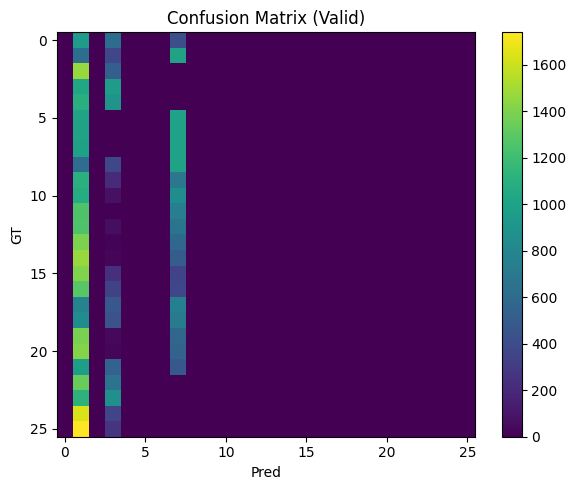

[Per-class IoU | bottom 5]
  class 1.0 -> IoU=0.0000
  class 24.0 -> IoU=0.0000
  class 23.0 -> IoU=0.0000
  class 22.0 -> IoU=0.0000
  class 21.0 -> IoU=0.0000
[Per-class IoU | top 5]
  class 4.0 -> IoU=0.1015
  class 8.0 -> IoU=0.0702
  class 2.0 -> IoU=0.0199
  class 26.0 -> IoU=0.0000
  class 25.0 -> IoU=0.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if last_cm is not None and last_stats is not None:
    cm = last_cm.numpy().astype(np.int64)
    idx2lbl = dataset.idx2lbl
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title("Confusion Matrix (Valid)")
    plt.xlabel("Pred"); plt.ylabel("GT")
    plt.colorbar(); plt.tight_layout(); plt.show()

    iou = last_stats["iou_per_class"]
    classes = [idx2lbl[i] for i in range(len(iou))]
    order = np.argsort(iou)
    print("[Per-class IoU | bottom 5]")
    for i in order[:5]: print(f"  class {classes[i]} -> IoU={iou[i]:.4f}")
    print("[Per-class IoU | top 5]")
    for i in order[-5:][::-1]: print(f"  class {classes[i]} -> IoU={iou[i]:.4f}")
else:
    print("[INFO] 아직 last_cm/last_stats가 없습니다. 학습 루프부터 실행하세요.")


In [ ]:
# 실제 생성된 XYZ 파일로 테스트
#xyz_test = str((Path(r"..\assets\ply\impeller\4wings\xyz") / "impeller_b3_010_point.xyz"))
#ckpt     = save_path
#out_xyzc = str(Path(xyz_test).with_name("impeller_b3_010_pred.xyzc"))
#print(infer_xyz_to_xyzc(xyz_test, ckpt, out_path=out_xyzc))
